# **Dataset: ClinicCVC**

## **1. Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data_path = "./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggle"

In [ ]:
import os
os.listdir(data_path)

['class_dict.csv',
 'metadata.csv',
 'TIF',
 'PNG',
 'UNet_model.pth',
 'PAN_model.pth',
 'FPN_model.pth',
 'UNetPlusPlus_model.pth',
 'DeepLabV3.pth']

In [ ]:
!pip install torch==1.6.0 torchvision==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 58.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.6.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.6.0 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.6

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
import sys
print(torch.__version__)
print (sys.version)

1.6.0
3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]


In [ ]:
!pip install -q -U segmentation-models-pytorch==0.2.0 albumentations #> /dev/null  # 0.1.2
# !pip install timm==0.4.12
# import segmentation_models_pytorch as smp

     |████████████████████████████████| 87 kB 6.8 MB/s 
     |████████████████████████████████| 123 kB 69.6 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 376 kB 62.9 MB/s 


In [ ]:
# !pip install timm==0.1.20
import segmentation_models_pytorch as smp

## **2. Data Loading and Processing**

In [ ]:
info_df = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
info_df = info_df[['frame_id', 'png_image_path', 'png_mask_path']]

info_df.head()

496 55 61


In [ ]:
info_df['png_mask_path'] = info_df['png_mask_path'].apply(lambda img_pth: os.path.join(data_path, img_pth))
info_df['png_image_path'] = info_df['png_image_path'].apply(lambda img_pth: os.path.join(data_path, img_pth))
info_df = info_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Perform 80/10/10 split for Training / Validation / Testing
train_size = int((80/100)*len(info_df))
valid_size = int((10/100)*len(info_df))		
test_size = int((10/100)*len(info_df))

valid_df = info_df.sample(frac=0.1, random_state=42)
train_df = info_df.drop(valid_df.index)
test_df = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(test_df.index)

print(len(train_df), len(test_df), len(valid_df))

In [ ]:
info_df.head()

,frame_id,png_image_path,png_mask_path
0,184,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...
1,418,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...
2,311,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...
3,337,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...
4,291,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...,./gdrive/MyDrive/CSE575_SML/CVC_ClinicDB_Kaggl...


In [ ]:
rgb_classes = class_dict[['r','g','b']].values.tolist()
class_dict = pd.read_csv(os.path.join(data_path, 'class_dict.csv'))
class_names = class_dict['class_names'].tolist()


print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', rgb_classes)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
select_classes = ['background', 'polyp']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_rgb_classes =  np.array(rgb_classes)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', rgb_classes)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
def visualize(**images):
    # n_images = len(images)
    plt.figure(figsize=(18,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [ ]:
class EndoscopyDataset(torch.utils.data.Dataset):

    def __init__(self, df, rgb_classes=None, augmentation=None, preprocessing=None):
        self.rgb_classes = rgb_classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.image_paths = df['png_image_path'].tolist()
        self.mask_paths = df['png_mask_path'].tolist()
        
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)        
        mask = one_hot_encode(mask, self.rgb_classes).astype('float')
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']            
        
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

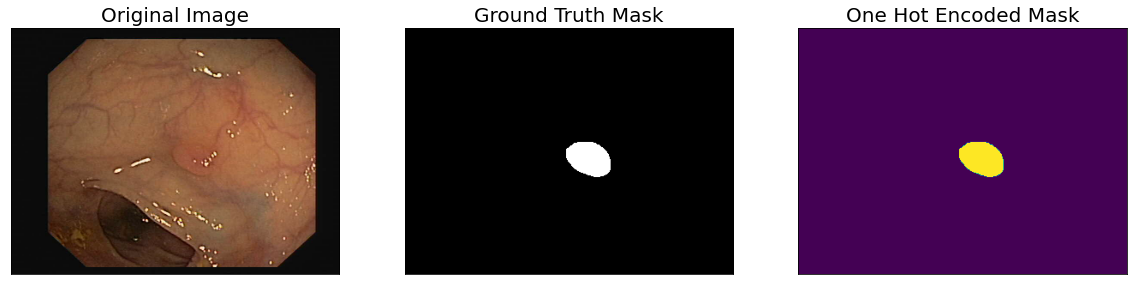

In [ ]:
dataset = EndoscopyDataset(train_df, rgb_classes=select_rgb_classes)

In [ ]:
def train_augment():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)

def valid_augment():
    test_transform = [album.PadIfNeeded(min_height=288, min_width=384, always_apply=True, border_mode=0)]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    transforms = []
    if preprocessing_fn:
        transforms.append(album.Lambda(image=preprocessing_fn))
    transforms.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(transforms)

In [ ]:
augmented_dataset = EndoscopyDataset(train_df, augmentation=train_augment(),rgb_classes=select_rgb_classes)

## **3. Models**

### **i) UNet**

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
TRAINING = True

num_epochs = 10
BATCH_SIZE = 16
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_dataset = EndoscopyDataset(
    train_df, 
    augmentation=train_augment(),
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

valid_dataset = EndoscopyDataset(
    valid_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

test_dataset = EndoscopyDataset(
    test_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

#### Actual Version

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device_type,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, num_epochs):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, dice_loss - 0.06666, iou_score - 0.9691]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, dice_loss - 0.05994, iou_score - 0.968]

Epoch: 2
valid: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, dice_loss - 0.05094, iou_score - 0.9735]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, dice_loss - 0.04748, iou_score - 0.9684]

Epoch: 4
train:   0%|          | 0/31 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, os.path.join(data_path, 'UNet_model.pth'))

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
test_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, dice_loss - 0.04436, iou_score - 0.9751]
Evaluation on Test Data: 
Mean IoU Score: 0.9684
Mean Dice Loss: 0.0475


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
print(train_logs_df.T)

                  0         1         2         3
dice_loss  0.067943  0.059359  0.051597  0.044270
iou_score  0.976702  0.976183  0.978331  0.981564


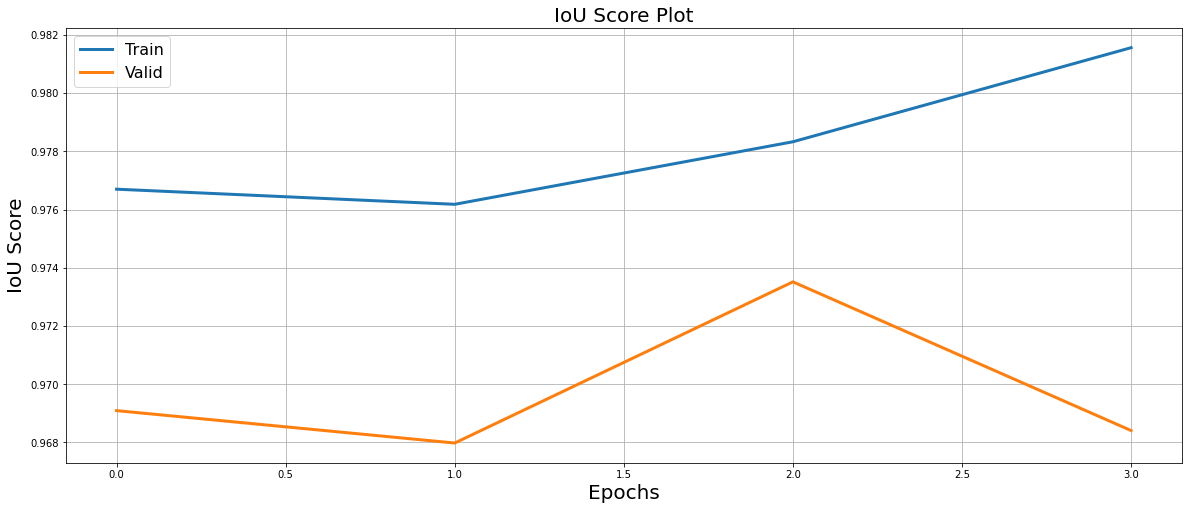

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('iou_score_plot.png')
plt.show()

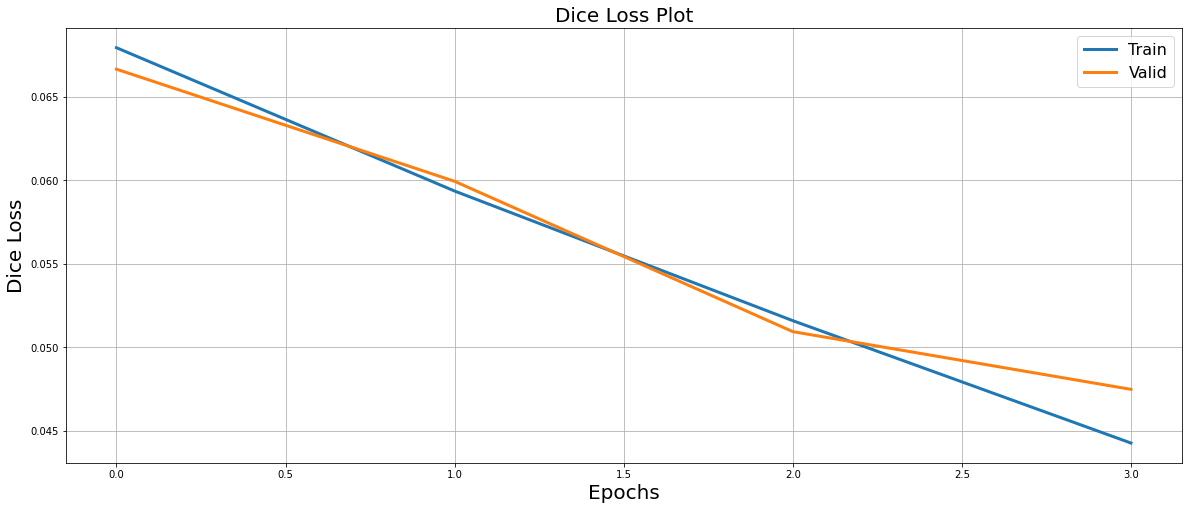

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.sa  vefig('dice_loss_plot.png')
plt.show()

### **ii) FPN**

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
TRAINING = True

num_epochs = 10
BATCH_SIZE = 16
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_dataset = EndoscopyDataset(
    train_df, 
    augmentation=train_augment(),
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

valid_dataset = EndoscopyDataset(
    valid_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

test_dataset = EndoscopyDataset(
    test_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device_type,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, num_epochs):

        # Perform training & validation
        print('\nEpoch: {}'.format(i+1))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            # torch.save(model, './best_model.pth')
            torch.save(model, os.path.join(data_path, 'FPN_model.pth'))
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, dice_loss - 0.08927, iou_score - 0.8362]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, dice_loss - 0.07638, iou_score - 0.8593]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, dice_loss - 0.06439, iou_score - 0.8796]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, dice_loss - 0.06182, iou_score - 0.8843]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, dice_loss - 0.05744, iou_score - 0.892]
Model saved!


In [ ]:
torch.save(model, os.path.join(data_path, 'FPN_model.pth'))

In [ ]:
model = torch.load(os.path.join(data_path, 'FPN_model.pth'))

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
test_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, dice_loss - 0.04936, iou_score - 0.9065]
Evaluation on Test Data: 
Mean IoU Score: 0.8920
Mean Dice Loss: 0.0574


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
print(train_logs_df.T)

                  0         1         2         3         4
dice_loss  0.106297  0.087927  0.066033  0.061034  0.057848
iou_score  0.816518  0.839453  0.877015  0.885770  0.891425


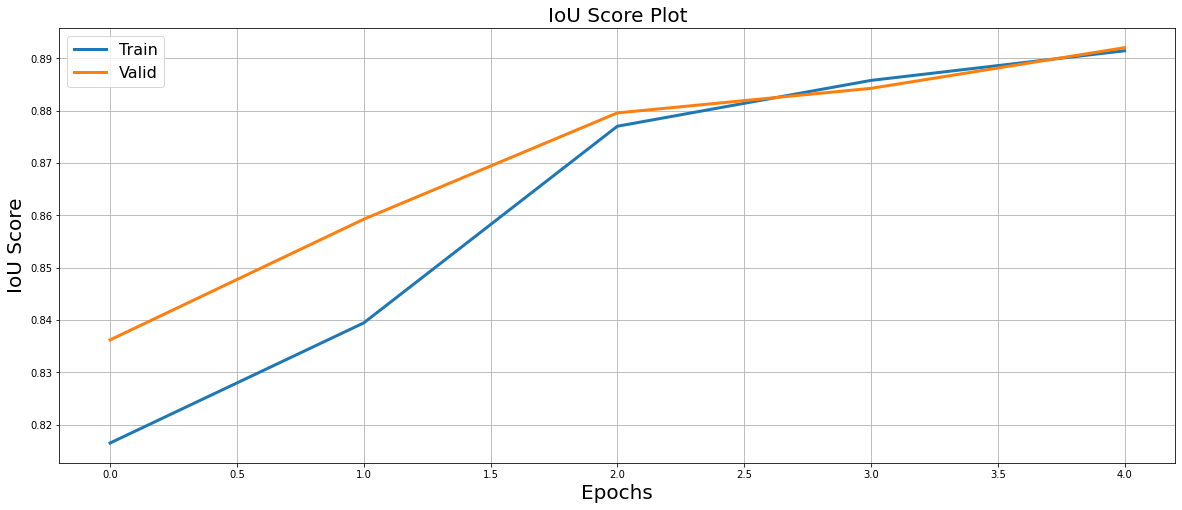

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('iou_score_plot.png')
plt.show()

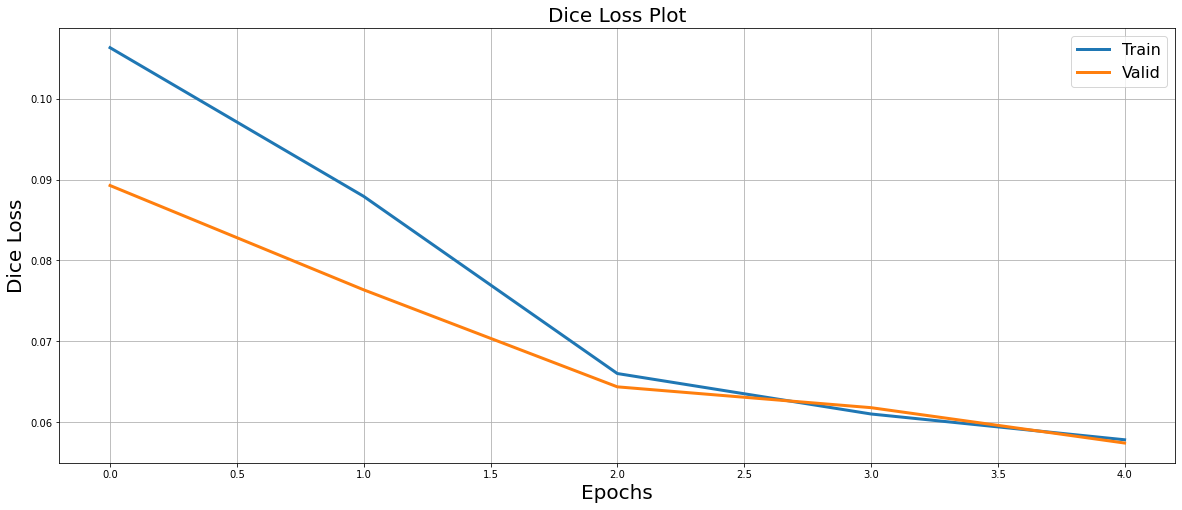

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.sa  vefig('dice_loss_plot.png')
plt.show()

### **iii) PAN**

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.PAN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
TRAINING = True

num_epochs = 10
BATCH_SIZE = 16
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_dataset = EndoscopyDataset(
    train_df, 
    augmentation=train_augment(),
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

valid_dataset = EndoscopyDataset(
    valid_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

test_dataset = EndoscopyDataset(
    test_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device_type,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, num_epochs):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            # torch.save(model, './best_model.pth')
            torch.save(model, os.path.join(data_path, 'PAN_model.pth'))
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, dice_loss - 0.1133, iou_score - 0.8794]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, dice_loss - 0.05628, iou_score - 0.9351]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, dice_loss - 0.0436, iou_score - 0.9456]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, dice_loss - 0.03509, iou_score - 0.952]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, dice_loss - 0.03265, iou_score - 0.9526]
Model saved!


In [ ]:
torch.save(model, os.path.join(data_path, 'PAN_model.pth'))

In [ ]:
model = torch.load(os.path.join(data_path, 'PAN_model.pth'))

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
test_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, dice_loss - 0.02552, iou_score - 0.9665]
Evaluation on Test Data: 
Mean IoU Score: 0.9526
Mean Dice Loss: 0.0326


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
print(train_logs_df.T)

                  0         1         2         3         4
dice_loss  0.227976  0.074278  0.046977  0.035872  0.030190
iou_score  0.721520  0.920879  0.944898  0.955771  0.960246


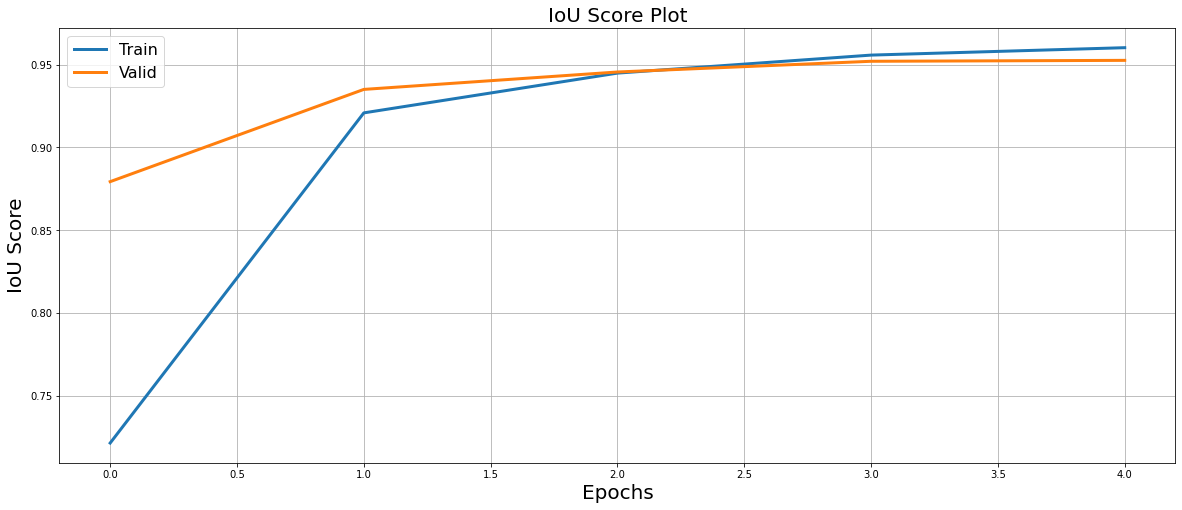

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('iou_score_plot.png')
plt.show()

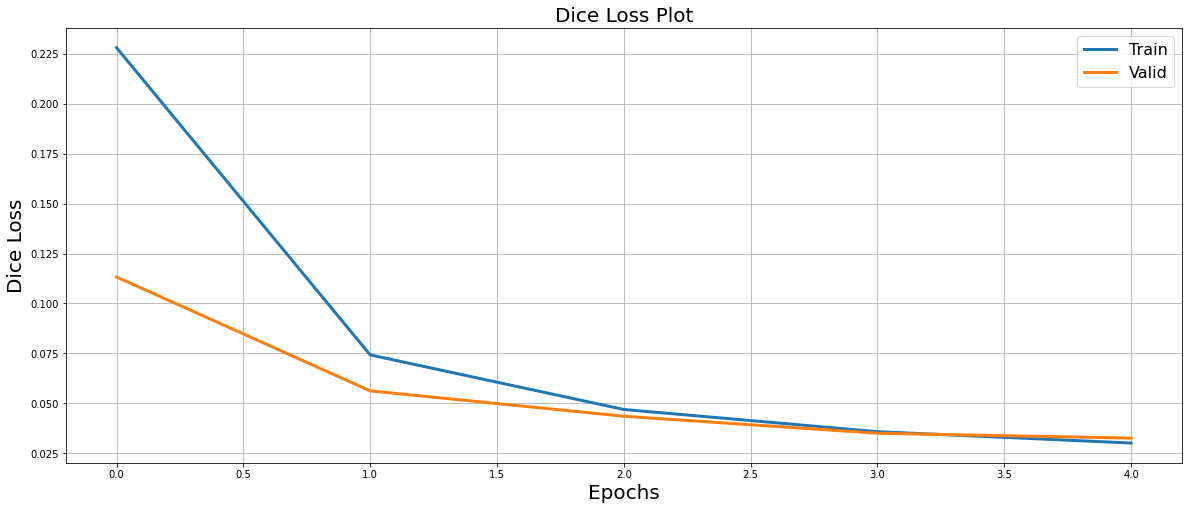

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.sa  vefig('dice_loss_plot.png')
plt.show()

### **iv) UNet Plus Plus**

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.    (
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
TRAINING = True

num_epochs = 10
BATCH_SIZE = 16
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_dataset = EndoscopyDataset(
    train_df, 
    augmentation=train_augment(),
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

valid_dataset = EndoscopyDataset(
    valid_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

test_dataset = EndoscopyDataset(
    test_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device_type,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, num_epochs):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            # torch.save(model, './best_model.pth')
            torch.save(model, os.path.join(data_path, 'UNetPlusPlus_model.pth'))
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, dice_loss - 0.3061, iou_score - 0.7126]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, dice_loss - 0.288, iou_score - 0.7189]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, dice_loss - 0.2575, iou_score - 0.7381]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, dice_loss - 0.2454, iou_score - 0.7196]

Epoch: 4
valid: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, dice_loss - 0.2119, iou_score - 0.9497]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, dice_loss - 0.1883, iou_score - 0.9675]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, dice_loss - 0.1686, iou_score - 0.9785]
Model saved!

Epoch: 7
valid: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, dice_loss - 0.1499, iou_score - 0.9783]

Epoch: 8
valid: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, dice_loss - 0.1351, iou_score - 0.97

KeyboardInterrupt: ignored

In [ ]:
model = torch.load(os.path.join(data_path, 'UNetPlusPlus_model.pth'))

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
test_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 4/4 [00:27<00:00,  6.82s/it, dice_loss - 0.1359, iou_score - 0.9478]
Evaluation on Test Data: 
Mean IoU Score: 0.9756
Mean Dice Loss: 0.1250


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
print(train_logs_df.T)

                  0         1         2         3         4         5  \
dice_loss  0.322677  0.297230  0.272338  0.250050  0.228559  0.202474   
iou_score  0.688757  0.701878  0.715392  0.720058  0.823727  0.959827   

                  6         7         8         9  
dice_loss  0.178380  0.158884  0.143918  0.131217  
iou_score  0.972268  0.978233  0.976398  0.974293  


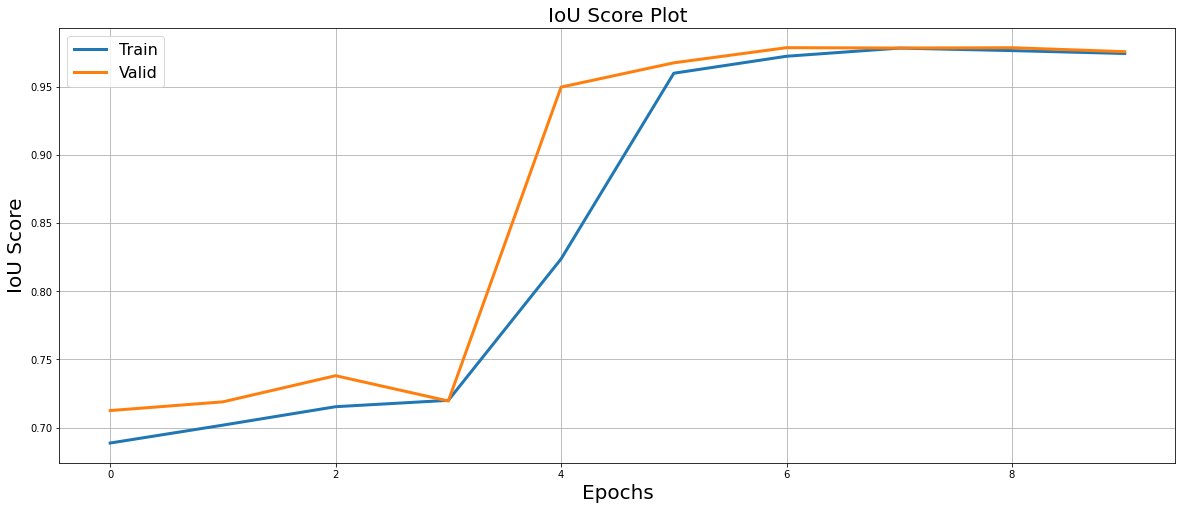

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('iou_score_plot.png')
plt.show()

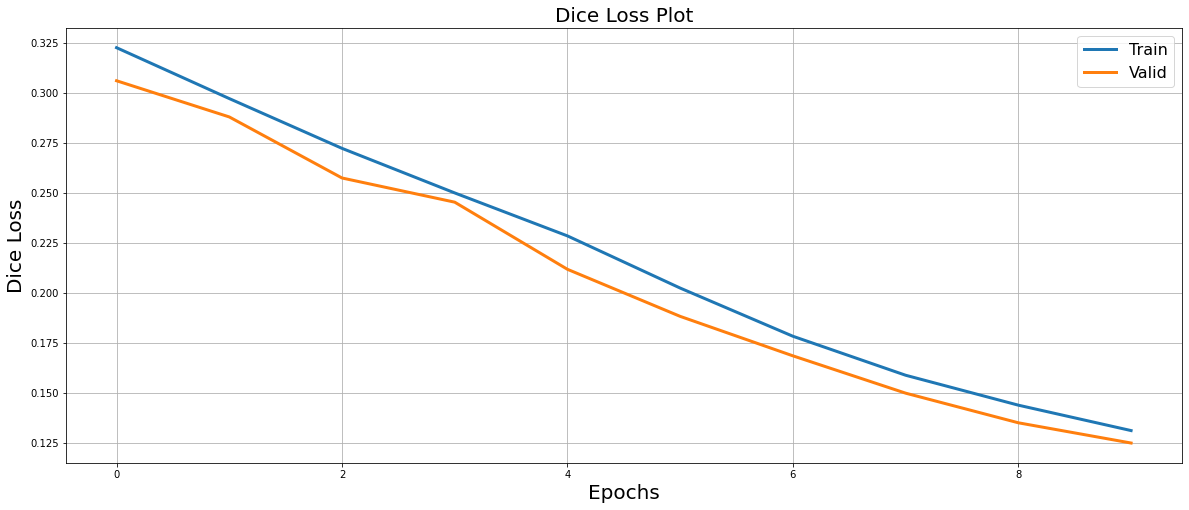

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.sa  vefig('dice_loss_plot.png')
plt.show()

### **v) DeepLabV3**

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
TRAINING = True

num_epochs = 20
BATCH_SIZE = 16
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_dataset = EndoscopyDataset(
    train_df, 
    augmentation=train_augment(),
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

valid_dataset = EndoscopyDataset(
    valid_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

test_dataset = EndoscopyDataset(
    test_df, 
    augmentation=valid_augment(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    rgb_classes=select_rgb_classes,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device_type,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, num_epochs):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            # torch.save(model, './best_model.pth')
            torch.save(model, os.path.join(data_path, 'DeepLabV3.pth'))
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:20<00:00,  5.19s/it, dice_loss - 0.2275, iou_score - 0.8932]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it, dice_loss - 0.1732, iou_score - 0.942]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, dice_loss - 0.1498, iou_score - 0.9539]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, dice_loss - 0.1262, iou_score - 0.9616]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, dice_loss - 0.1107, iou_score - 0.9602]

Epoch: 5
valid: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, dice_loss - 0.09151, iou_score - 0.967]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, dice_loss - 0.07957, iou_score - 0.9652]

Epoch: 7
valid: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, dice_loss - 0.06918, iou_score - 0.9709]
Model saved!

Epoch: 8
valid: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, dice_loss - 0.07976, iou_score - 0

KeyboardInterrupt: ignored

In [ ]:
model = torch.load(os.path.join(data_path, 'DeepLabV3.pth'))

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device_type,
    verbose=True,
)

In [ ]:
test_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 4/4 [00:20<00:00,  5.07s/it, dice_loss - 0.05235, iou_score - 0.967]
Evaluation on Test Data: 
Mean IoU Score: 0.9716
Mean Dice Loss: 0.0500


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
print(train_logs_df.T)

                 0         1         2         3         4         5   \
dice_loss  0.339643  0.217740  0.172375  0.140182  0.115686  0.096897   
iou_score  0.700526  0.915147  0.946561  0.959752  0.966714  0.970339   

                 6         7         8         9         10  
dice_loss  0.082132  0.070746  0.065013  0.056693  0.049513  
iou_score  0.974953  0.976891  0.972606  0.975834  0.978780  


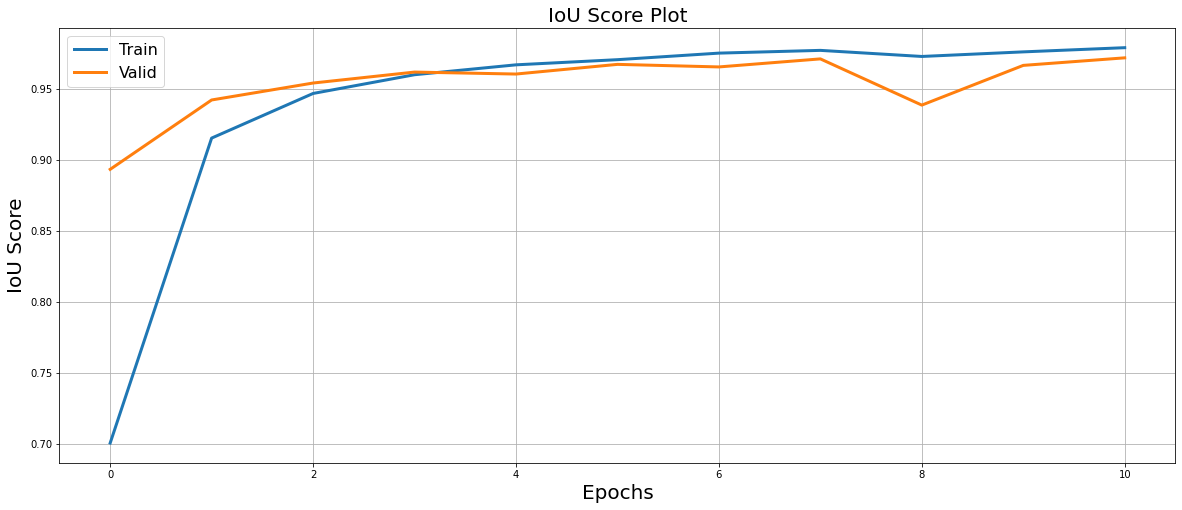

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('iou_score_plot.png')
plt.show()

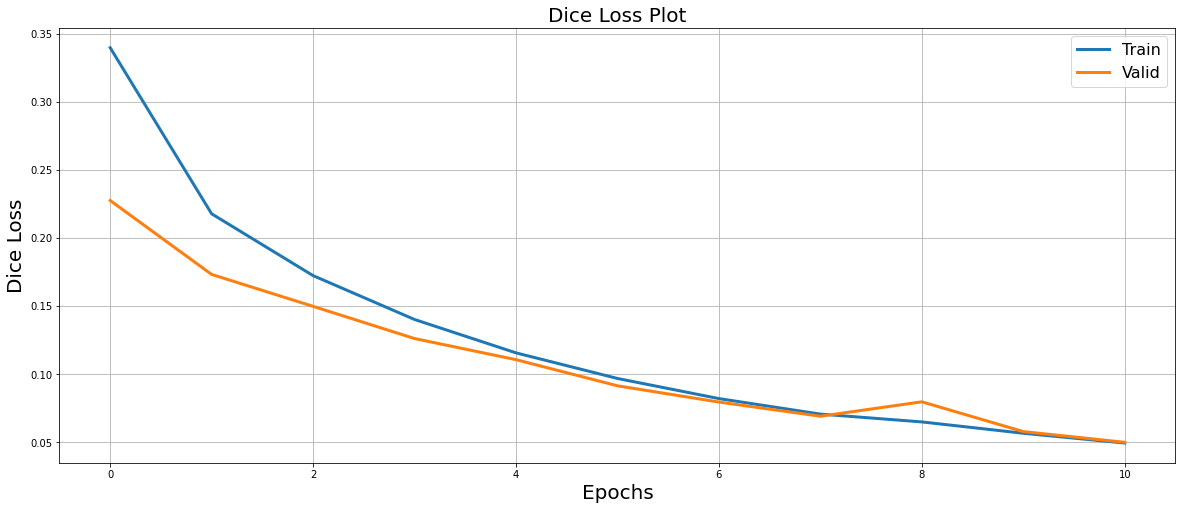

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.sa  vefig('dice_loss_plot.png')
plt.show()